# Improving Speech Recognition Output Using a Classical Language Model

Steps:
- Installing and compiling KenLM
- Downloading Wikipedia datase
- Training 1-gram, 2-gram, 3-gram
- Evaluation

## 1. Setup


In [ ]:
!pip install https://github.com/kpu/kenlm/archive/master.zip
!pip install datasets pandas matplotlib

In [ ]:
import os


if not os.path.exists("kenlm/build/bin/lmplz"):
    print("Downloading and compiling KenLM...")
    if not os.path.exists("kenlm"):
        !git clone https://github.com/kpu/kenlm.git
    
    # dirty fix for macos compatibility
    # couldn't find the better way to make it work
    cmake_file = "kenlm/CMakeLists.txt"
    if os.path.exists(cmake_file):  
        with open(cmake_file, "r") as f:
            content = f.read()
        
        # remove 'system' and 'unit_test_framework'
        if "find_package(Boost 1.41.0 REQUIRED COMPONENTS" in content:
            new_content = content.replace("system", "").replace("unit_test_framework", "")
            if new_content != content:
                print("Patching CMakeLists.txt to fix Boost dependencies...")
                with open(cmake_file, "w") as f:
                    f.write(new_content)
    



    !mkdir -p kenlm/build
    %cd kenlm/build
    !rm -rf CMakeCache.txt CMakeFiles
    !cmake .. -DBoost_NO_BOOST_CMAKE=ON
    !make -j 4
    %cd ../..
    print("Done!")
else:
    print("KenLM binaries already exist")


KENLM_BIN = "./kenlm/build/bin/lmplz"

Cloning into 'kenlm'...
remote: Enumerating objects: 14185, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 14185 (delta 117), reused 81 (delta 81), pack-reused 14009 (from 2)
Receiving objects: 100% (14185/14185), 5.91 MiB | 8.04 MiB/s, done.
Resolving deltas: 100% (8059/8059), done.
Patching CMakeLists.txt to fix Boost dependencies...
/Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/kenlm/build
-- The C compiler identification is AppleClang 17.0.0.17000603
-- The CXX compiler identification is AppleClang 17.0.0.17000603
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting C

In [2]:
import pandas as pd
import json
import kenlm
import re
from datasets import load_dataset


pd.set_option('display.max_colwidth', None)

## 2. Dataset

Using Wikipedia dataset with 25000 examples

In [3]:
dataset = load_dataset("wikimedia/wikipedia", "20231101.uk", split="train[:25000]")
print(f"Loaded {len(dataset)} examples")

Loaded 25000 examples


In [4]:
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()


training_file = "data/sample_25000.txt"

with open(training_file, "w", encoding="utf-8") as f:
    for item in dataset:
        if item['text']:
            clean_line = preprocess_text(item['text'])
            f.write(clean_line + "\n")


print(f"Saved training corpus to {training_file}")

Saved training corpus to data/sample_25000.txt


## 3. Training

Since KenLM doesn't support 1-gram models, the simplest workaround is to add a fake bigram section to the ARPA file

In [5]:
def patch_1gram_arpa(arpa_path):
    with open(arpa_path, 'r') as f:
        content = f.read()
    
    if "ngram 2=" in content:
        return

    lines = content.split('\n')
    new_lines = []
    
    # header fix
    for line in lines:
        new_lines.append(line)
        if line.startswith("ngram 1="):
            new_lines.append("ngram 2=1")

    # section fix
    end_idx = -1
    for i, line in enumerate(new_lines):
        if line.strip() == "\\end\\":
            end_idx = i
            break
            
    if end_idx != -1:
        fake_bigram_section = [
            "",
            "\\2-grams:",
            "-99 <s> </s>", # fake bigram
        ]
        new_lines = new_lines[:end_idx] + fake_bigram_section + new_lines[end_idx:]
    
    with open(arpa_path, 'w') as f:
        f.write('\n'.join(new_lines))
    
    print(f"Patched {arpa_path} to bypass KenLM 1-gram restriction")

In [8]:
import os


orders = [1, 2, 3]
models_paths = {}


for n in orders:
    arpa_file = f"models/sample_25000_{n}gram.arpa"
    binary_file = f"models/sample_25000_{n}gram.binary"
    
    print(f"Training {n}-gram model...")
    

    cmd = f"{KENLM_BIN} -o {n} --text {training_file} --arpa {arpa_file} --discount_fallback"
    !{cmd} > /dev/null 2>&1
    
    if os.path.exists(arpa_file) and os.path.getsize(arpa_file) > 0:
        # patch 1-gram model
        if n == 1:
            patch_1gram_arpa(arpa_file)
            
        models_paths[n] = arpa_file
        print(f"Created {arpa_file}")
    else:
        print(f"Error creating {arpa_file}")

Training 1-gram model...
Patched models/sample_25000_1gram.arpa to bypass KenLM 1-gram restriction
Created models/sample_25000_1gram.arpa
Training 2-gram model...
Created models/sample_25000_2gram.arpa
Training 3-gram model...
Created models/sample_25000_3gram.arpa


## 4. Scoring

Loading `ua_asr_hypotheses_500.jsonl` and using perplexity calculation function:

$$ Perplexity = 10^{-\frac{\log_{10} P}{N}} $$

In [9]:
test_data = []
with open("data/ua_asr_hypotheses_500.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        test_data.append(json.loads(line))


print(f"Loaded {len(test_data)} test cases")
print("Example:", test_data[0])

Loaded 500 test cases
Example: {'utt_id': 'ua_title_0000', 'reference': 'Вайлдер — Ортіс: відео нокауту', 'hypotheses': ['Вайлдер — Ортіс: відео нокауту', 'Вайлдер — Ортіз: видео нокауту', 'Вайлдер — Ортіс: видео нокоуту', 'Вайлдер Вайлтер — Ортіс: відео нокоуту нокауту', 'Войлтер — Ортіс: відео накауту', 'Вайлдер — Ортіс: вітео нокауту', 'Вайлдер — Ортіс: відеа нокауту', 'Войлдер — Ортіз: вітео нокауту']}


In [11]:
import re


def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w]', '', text)
    return text


def calculate_perplexity(model, sentence):
    log_prob = model.score(sentence, bos=True, eos=True)
    words = sentence.split()
    N = len(words) + 1 
    if N == 0: return float('inf')
    return 10 ** (-log_prob / N)


def evaluate_model(model_path, data):
    model = kenlm.Model(model_path)
    correct_count = 0
    soft_correct_count = 0
    total_count = len(data)
    
    results = []
    
    for item in data:
        reference = item['reference']
        hypotheses = item['hypotheses']
        
        best_hyp = None
        min_ppl = float('inf')
        
        for hyp in hypotheses:
            ppl = calculate_perplexity(model, hyp)
            if ppl < min_ppl:
                min_ppl = ppl
                best_hyp = hyp
        
        is_correct = (best_hyp == reference)
        if is_correct:
            correct_count += 1
            
        is_soft_correct = (normalize_text(best_hyp) == normalize_text(reference))
        if is_soft_correct:
            soft_correct_count += 1
            
        results.append({
            "reference": reference,
            "selected": best_hyp,
            "is_correct": is_correct,
            "is_soft_correct": is_soft_correct,
            "perplexity": min_ppl
        })
        
    accuracy = correct_count / total_count
    soft_accuracy = soft_correct_count / total_count
    
    print(f"Exact accuracy: {accuracy:.2%} | Normalized accuracy: {soft_accuracy:.2%}")
    return accuracy, soft_accuracy, results

Launches evaluation for each trained model

In [12]:
comparison_results = {}
detailed_logs = {}

for n, path in models_paths.items():
    print(f"Evaluating {n}-gram model...")
    acc, soft_acc, logs = evaluate_model(path, test_data)
    comparison_results[f"{n}-gram"] = {'exact': acc, 'soft': soft_acc}
    detailed_logs[n] = logs


df_results = pd.DataFrame([
    {'Model': model, 'Exact accuracy': results['exact'], 'Normalized accuracy': results['soft']}
    for model, results in comparison_results.items()
])

display(df_results)

Evaluating 1-gram model...


Loading the LM will be faster if you build a binary file.
Reading /Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/models/sample_25000_1gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.

Exact accuracy: 63.80% | Normalized accuracy: 77.40%
Evaluating 2-gram model...
Exact accuracy: 72.80% | Normalized accuracy: 84.80%
Evaluating 3-gram model...
Exact accuracy: 72.60% | Normalized accuracy: 84.80%



Reading /Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/models/sample_25000_2gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/models/sample_25000_3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


,Model,Exact accuracy,Normalized accuracy
0,1-gram,0.638,0.774
1,2-gram,0.728,0.848
2,3-gram,0.726,0.848


## 5. Error analysis

Examples where 3-gram model made mistakes

In [13]:
errors_3gram_soft = [res for res in detailed_logs[3] if not res['is_soft_correct']]


print(f"Total hard errors (3-gram): {len(errors_3gram_soft)} (out of 500)")
print("Sample HARD errors:")


for i in range(min(10, len(errors_3gram_soft))):
    err = errors_3gram_soft[i]
    print(f"Ref: {err['reference']}")
    print(f"Sel: {err['selected']}")
    print("-" * 20)

Total hard errors (3-gram): 76 (out of 500)
Sample HARD errors:
Ref: На Зеленського немає компромату, бо він з іншої опери, - Коломойський
Sel: На Зеленського немає кампромоту, бо він він з іншої опери, - Коломойський
--------------------
Ref: Волонтери через брак коштів припиняють вивезення тіл загиблих із зони АТО
Sel: Волонтери через брак коштів припиняють вивезення тіл загиблих із зоні АТО
--------------------
Ref: СТАХОВСЬКИЙ: «Матч Ференцвароша в літаку додивлявся. Ребров – герой»
Sel: СТАХОВСЬКИЙ: « Матч Ференцвароша в в літаку дотивлявся. Ребров – герой »
--------------------
Ref: Мірча ЛУЧЕСКУ: «Ми не розслабилися, коли виграли чемпіонат України»
Sel: Мірча ЛУЧЕСКУ: « Ми ж розслабилися, коли виграли чемпіонат України »
--------------------
Ref: Примітивна економіка. Як Україні вибратися із пастки сировинної моделі
Sel: Примітивна економіка. Як України вибротися із пастки сировинної моделі
--------------------
Ref: Єрмак пропонує прийняти закон, що каратиме за публікацію "просл

## 6. Dataset size experiments

Comparing accuracy with different dataset sizes - 10k, 50k, 200k, 500k, 1M

In [18]:
data_sizes = [10000, 50000, 100000, 200000, 500000]
size_results = {}


for size in data_sizes:
    print(f"\nExperiment with dataset size: {size}")

    dataset = load_dataset("wikimedia/wikipedia", "20231101.uk", split=f"train[:{size}]")
    
    subset_file = f"data/train_{size}.txt"
    with open(subset_file, "w", encoding="utf-8") as f:
        count = 0
        for item in dataset:
            if count >= size: break
            if item['text']:
                f.write(preprocess_text(item['text']) + "\n")
                count += 1
    
    arpa_path = f"models/model_{size}_3gram.arpa"
    !{KENLM_BIN} -o 3 --text {subset_file} --arpa {arpa_path} --discount_fallback > /dev/null 2>&1
    

    # scores
    acc, soft_acc, _ = evaluate_model(arpa_path, test_data)
    size_results[size] = {'exact': acc, 'soft': soft_acc}



Experiment with dataset size: 10000


Loading the LM will be faster if you build a binary file.
Reading /Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/models/model_10000_3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


Exact accuracy: 73.00% | Normalized accuracy: 82.60%

Experiment with dataset size: 50000


Loading the LM will be faster if you build a binary file.
Reading /Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/models/model_50000_3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


Exact accuracy: 72.40% | Normalized accuracy: 85.00%

Experiment with dataset size: 100000


Loading the LM will be faster if you build a binary file.
Reading /Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/models/model_100000_3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


Exact accuracy: 72.20% | Normalized accuracy: 85.60%

Experiment with dataset size: 200000


Loading the LM will be faster if you build a binary file.
Reading /Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/models/model_200000_3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


Exact accuracy: 72.20% | Normalized accuracy: 85.40%

Experiment with dataset size: 500000
Exact accuracy: 71.80% | Normalized accuracy: 85.80%


Loading the LM will be faster if you build a binary file.
Reading /Users/markmatviyiv/studyspace/Natural Language Processing/homework_1/models/model_500000_3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


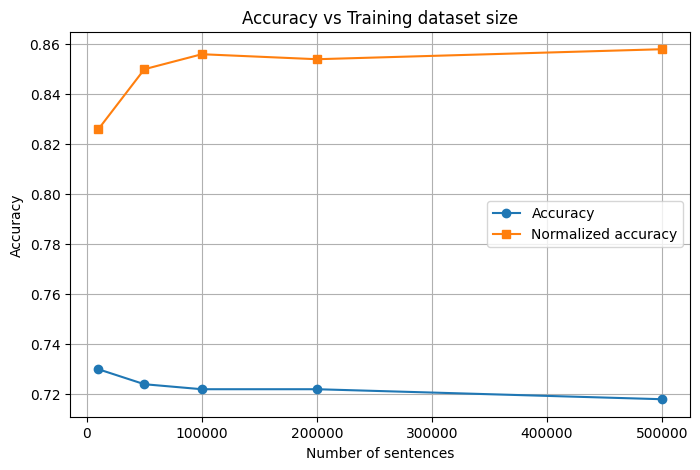

In [19]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))

# Extract data for plotting
sizes = list(size_results.keys())
exact_accs = [size_results[size]['exact'] for size in sizes]
soft_accs = [size_results[size]['soft'] for size in sizes]

# Plot both lines
plt.plot(sizes, exact_accs, marker='o', label='Accuracy')
plt.plot(sizes, soft_accs, marker='s', label='Normalized accuracy')

plt.title('Accuracy vs Training dataset size')
plt.xlabel('Number of sentences')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()